<h1>Time series anomaly detection</h1>

In this notebook we will study novelty detection with time series in order to detect abnormal patterns.

We'll use as dataset Bitcoin's closing price since 2014.

<h2>Part I - Quick Data Exploration</h2>

In [1]:
import pandas as pd
import numpy as np

input_df = pd.read_csv(r'btc-price.csv')
input_df.Date = pd.to_datetime(input_df.Date)
input_df = input_df.set_index('Date')
input_df = input_df.fillna(method='backfill')
print('Number of NaN values:\n' + str(input_df.isnull().sum()))
input_df.tail(10)

Number of NaN values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,51514.812500,3.587390e+10
2021-10-06,51486.664063,55568.464844,50488.191406,55361.449219,55361.449219,4.903473e+10
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,53805.984375,3.680786e+10
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,3.480087e+10
2021-10-09,53929.781250,55397.945313,53735.144531,54968.222656,54968.222656,3.249121e+10
2021-10-10,54952.820313,56401.304688,54264.257813,54771.578125,54771.578125,3.952779e+10
2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,4.263733e+10
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,4.108376e+10
2021-10-13,56038.257813,57688.660156,54370.972656,57401.097656,57401.097656,4.168425e+10


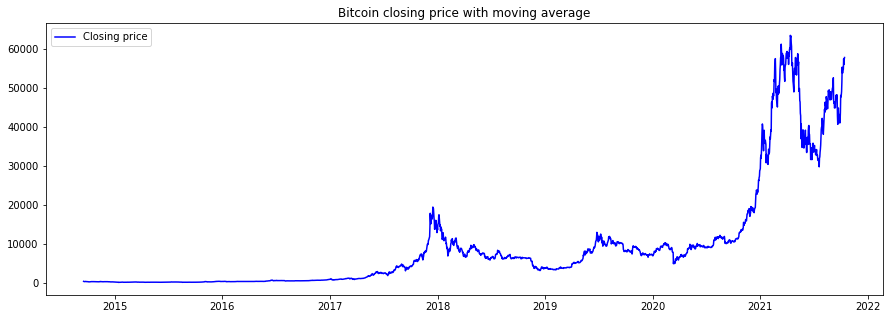

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(input_df['Close'], color='b', label='Closing price')
plt.title('Bitcoin closing price with moving average')
plt.legend()

<h2>Part II - Model creation</h2>

We'll train the algorithm on all data before January 2020, then we'll test it on data after this date.

We assume that there is no anomaly before January 2020.

In [3]:
train, test = input_df.loc[input_df.index <= '2020-01-01'], input_df.loc[input_df.index > '2020-01-01']
train.shape, test.shape

((1933, 6), (652, 6))

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\Seren\AppData\Local\Temp/ipykernel_13492/1564450779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
C:\Users\Seren\AppData\Local\Temp/ipykernel_13492/1564450779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [43]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (1903, 30, 1)
Testing shape: (622, 30, 1)


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.RepeatVector(X_train.shape[1]))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

Some explanations:
- RepeatVector layer adds an extra dimension to the output of the first LSTM.
- TimeDistributed layer allows to apply the same LSTM layer to each timestep.

In [8]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
54/54 [==============================] - 1s 17ms/step - loss: 0.1452 - val_loss: 0.3184
Epoch 2/100
54/54 [==============================] - 1s 14ms/step - loss: 0.1285 - val_loss: 0.2753
Epoch 3/100
54/54 [==============================] - 1s 13ms/step - loss: 0.1139 - val_loss: 0.2549
Epoch 4/100
54/54 [==============================] - 1s 13ms/step - loss: 0.1106 - val_loss: 0.2677
Epoch 5/100
54/54 [==============================] - 1s 14ms/step - loss: 0.1091 - val_loss: 0.2011
Epoch 6/100
54/54 [==============================] - 1s 13ms/step - loss: 0.1030 - val_loss: 0.2335
Epoch 7/100
54/54 [==============================] - 1s 13ms/step - loss: 0.1068 - val_loss: 0.1620
Epoch 8/100
54/54 [==============================] - 1s 13ms/step - loss: 0.0950 - val_loss: 0.1912
Epoch 9/100
54/54 [==============================] - 1s 13ms/step - loss: 0.1027 - val_loss: 0.1646- ETA: 0s - los
Epoch 10/100
54/54 [==============================] - 1s 13ms/step - loss: 0.0944 - v

<h2>Part III - Threshold search</h2>

In order to separate normal values from anomalies we need to set a threshold, when we reconstruct a point in time of a time serie the loss must be inferior to the threshold in order to be normal or else it is an anomaly.

Here we will just take the maximum loss error for the training set as threshold.

Reconstruction error threshold: 1.2046710900713011


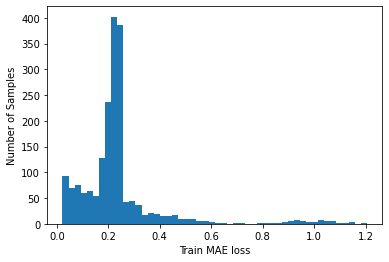

In [9]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

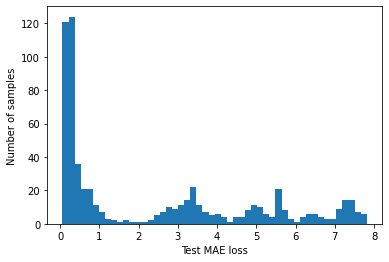

In [10]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

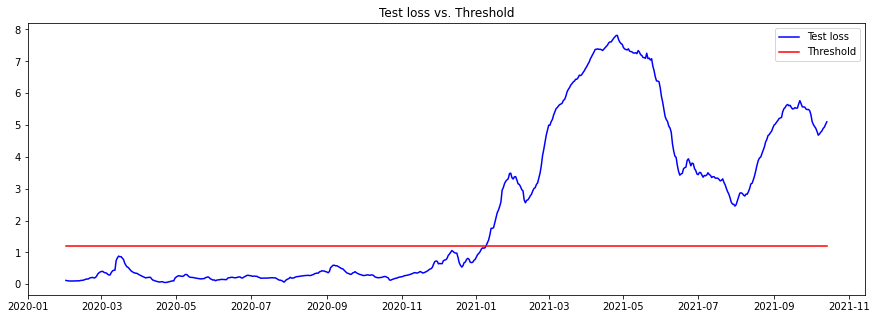

In [45]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

plt.figure(figsize=(15, 5))
plt.plot(test_score_df.index, test_score_df['loss'], color='b', label='Test loss')
plt.plot(test_score_df.index, test_score_df['threshold'], color='r', label='Threshold')
plt.title('Test loss vs. Threshold')
plt.legend()

In [16]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(279, 9)

In [33]:
print(scaler.inverse_transform(test_score_df[['Close']]).shape)

(622, 1)


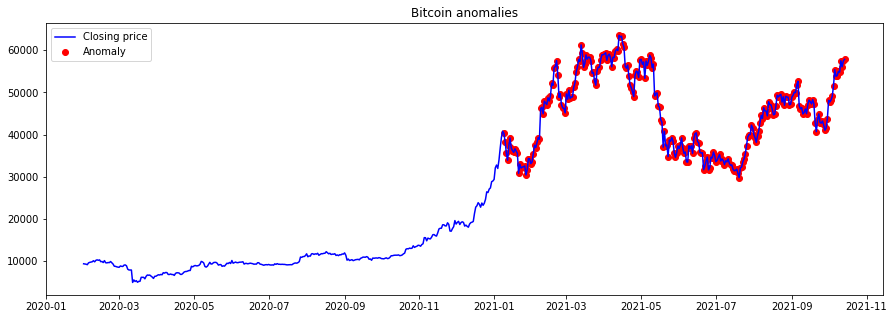

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(test_score_df.index, scaler.inverse_transform(test_score_df[['Close']]), color='b', label='Closing price')
plt.scatter(anomalies.index, scaler.inverse_transform(anomalies[['Close']]), color='r', label='Anomaly')
plt.title('Bitcoin anomalies')
plt.legend()

As you can see everything past 2021 is an anomaly because events and market manipulation exist and thus the price change.